In [1]:
suppressPackageStartupMessages({
    library(sna)
    library(testthat)
    library(network)
    library(ergm)
})



# Testing network structure
In this tutorial we will try to ascertain what features of networks are indicative of what tie-formation mechanisms. We will do this by
* Calculating the metrics from week 1, and
* Compare observed metrics against null distributions

For an example network, you will test different features against the models

1. $X \thicksim \mathrm{Bern}(p)$: the Bernoulli model
2. $X \thicksim U \mid L$: the conditional uniform model, conditional on density
3. $X \thicksim U \mid d$: the conditional uniform model, conditional on the degree distribution
4. $X \thicksim \mathrm{ERGM}(\theta,L)$: a density conditioned exponential random graph model 

Each random graph model is a distribution of probability over the space of all networks $\mathcal{X}=\{ 0, 1\}^{V \choose 2}$ or over a subset of $\mathcal{X}$.

## Hypothesis testing framework
Assume that the particular mechanism you are interested in is sensitive to a statistic $T(X)$ calculated for networks. Without loss of generality, assume that *large values of the statistic* is evidence for the mechanism. For example, if you belive that there is a tendency towards reciprocating ties in directed networks, then a greater number of mutual dyads 
$$
T(X) = \sum_{i < j}x_{ij}x_{ji}
$$
is evidence for a tendency towards reciprocation.

### Null distribution

The test and decision rule is

* Assume $H_0$: there is no mechanism *A*.
* Pick a random graph model $p(X)$ that is commensurate with $H_0$.
* Pick a statistic that measures evidence for *A*.
* Decision rule: If $\Pr\{ T(X) \geq T(X_{\mathrm{obs}}) \} < \alpha$, where $X$ are from distribution $p(X)$, reject $H_0$ on the $100 \% \times \alpha$-level of significance. 

Most of the time we cannot calculate the probability analytically and instead we use a *Monte Carlo* estimate of the probability. This Monte Carlo estimate is simply an average
$$
\hat{\Pr}\{T(X)> t \} = \frac{\sum_{k=1}^K I\{ T(X^{(k)}) \geq t\}}{K}
$$
where $X^{(1)},X^{(2)},\ldots,X^{(K)}$ is a sample of networks drawn from $p(X)$ and $I\{ B \}$ is an indicator function that is 1, if condition $B$ is true and 0 if $B$ is false.

> The proportion of graphs that as large a value on the statistic as the observed network, is a good approximation of the probability of observing something as large as $T(X_{\mathrm{obs}})$ under the assumption that the null-hypothesis is true

### What is a good null-model?

The purpose of this tutorial is to get an understanding of what a good null-distribution is. In general we will not be able to find null-distributions $p(X)$ that represent every observed feature of realistic networks with the only excepton being the mechanism *A*. 

The interpretation of the test is always contingent on the tie-formation process under the null-distribution. Consequently, if your test rejects the null-hypothesis, the correct interpretation is

> The probability of observing something as large as we have observed is $\alpha$ if we were to assume that people form ties according to the process $p(X)$

Often, the null distributions translate into 'people form ties completely at random'.

## Density

In the week 1 lecture slides, there is an illustration of the difference between density and average degree for different size networks. The important lesson is that density does not 'scale' properly. 

### Exercise (Optional)

For the Bernoully graph, ties form independently for all dyads with probablility $p$. This means that the expected density 
$$
E\left\{ \tfrac{2}{n(n-1)} \sum_{i<j}X_{ij}\right\}=p
$$
of a Bernoulli graph is $p$.

Let $L(X)$ be the number of edges in an undirected graph. Recall that the denisty is calculated as
$$
d = \frac{L(X)}{n(n-1)/2}=\frac{\sum_{i < j }x_{ij}}{n(n-1)/2}
$$

And the average degree is defined as
$$
m = \frac{2L(X)}{n}=\frac{\sum_{i,j }x_{ij}}{n}
$$

For a Bernoulli graph with tie-probability $p=0.1$, plot the average degree $m$ (vertical axis) against network size $n$ (horisontal axis), for $n$ ranging from $5$ to $1000$.

*Hint*: first solve for $m$ in the formula for $d$


ANSWER:
\begin{aligned}
\frac{1}{10} &= \frac{L(X)}{n(n-1)/2} \\
\frac{1}{10} &=\frac{nm/2}{n(n-1)/2}\\
\frac{1}{10} &=\frac{m}{n-1}\\
m  &=\frac{n-1}{10}
\end{aligned}


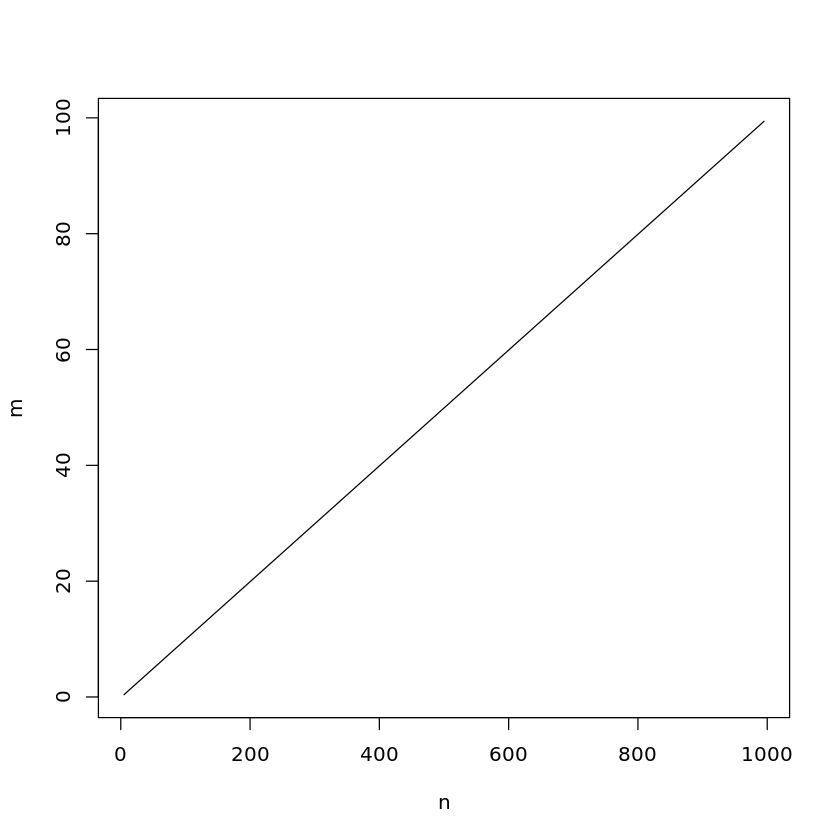

In [2]:
netsize <- seq(5,1000,by = 10) # a sequence of values of n, spaced 10 apart
# assign values m as a function of netsize
### BEGIN SOLUTION
m <- (netsize-1)/10
### END SOLUTION
plot(netsize,m,type='l',xlab='n',ylab='m')

> Different size networks require different density in order to get a realistic average degree

# Analysing Zachary's karate club


### Load data

Load the network of $n=34$ members of a karate club  (Zachary, 1977) from last week.

In [3]:
temp <- tempfile()
download.file("https://raw.githubusercontent.com/johankoskinen/BayesERGM/main/data/zachary.txt",temp)
X <-  read.table(temp)# this two adjacency matrices stacked on top of each other in a text file
unlink(temp)
X <- as.matrix(X[1:34,])# symmetric, binary, positive
n <- dim(X)[1]

## Completely random graph
Often we understand 'random' as a 50/50 chance, or a coin-toss. Let us compare the Karate network with a 'completely random' network.

We can generate the random network either using a standard random number generator

In [4]:
xrand <- matrix(runif(n*n),# random unit numbers between 0 and 1
                n, n)<0.5 # arrange these in an n times n matrix
# the probability that a random uniform number is smaller than 0.5 is 0.5
diag(xrand) <- 0 # remove accidental self-ties

or use the built-in random graph generator from `sna`

In [5]:
Xrand <- rgraph( n , # network size
                 tprob = 0.5 , # density
                 mode = 'graph') # we want an undirected network

This network should have approximately $L= 0.5n(n-1)/2=0.5\times 34 \times 33 /2= 280.1$ ties. Let's check

In [6]:
sum( Xrand )/2

[1] 283

Plot the observed and the random network

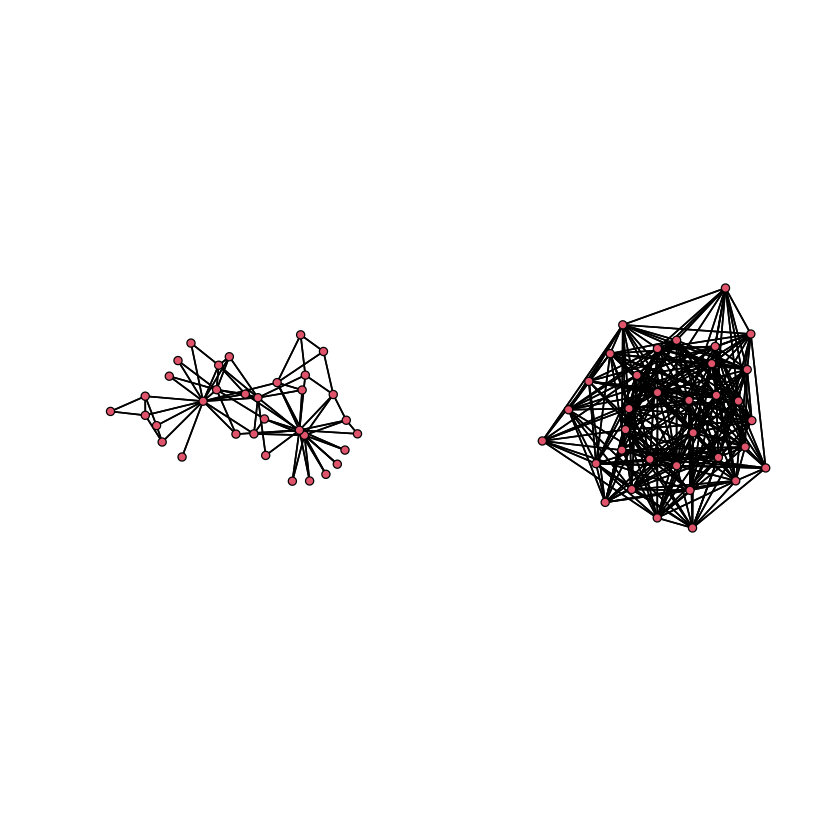

In [7]:
par( mfrow = c(1,2))
gplot( X , gmode='graph')
gplot( Xrand , gmode='graph')

It is clear that this random network is a poor representation of almost every aspect of the observed network. Note also that the average degree for the Karate club is

In [8]:
sum(X)/n

[1] 4.588235

and for the random network

In [9]:
sum(Xrand)/n

[1] 16.64706

# 1. Bernoulli graph
The Bernoulli graph $\mathrm{Bern}(p)$ assumes that tie-variables, independently for all dyads $\{i.j\} \in {V \choose 2}$, a tie is present with probability
$$
\Pr( X_{ij}=1) =  p
$$
The total number of ties $L(X)$ thus follows a $\mathrm{Binomial}(n(n-1)/2,p)$ distribution and the expected number of ties is
$$
E\{L(X) \}=E\left\{ \sum_{i<j}X_{ij} \right\}=pn(n-1)/2
$$
with expected density equal to $p$.

Commpare the Zachary dataset with random graphs that have *the same density on average* as the observed network. 

Draw 500 networks.

In [10]:
m <- 500
Xbern <- rgraph( n, # match network size
                 m= m, # generate 500 random networks
                 tprob = gden(X), # match tie-probability to density
                 mode='graph') # make sure these are undirected graphs

The networks are arranged in an array

In [11]:
dim(Xbern)# so 500 34 times 34 adjacency matrices
dim(Xbern[1,,])# the first slice of the array is the first simulated network

[1] 500  34  34

[1] 34 34

> Each network is a realisation on a variable and the Bernoulli model allocates a probability to every network!

### Plot network

Plot the first network

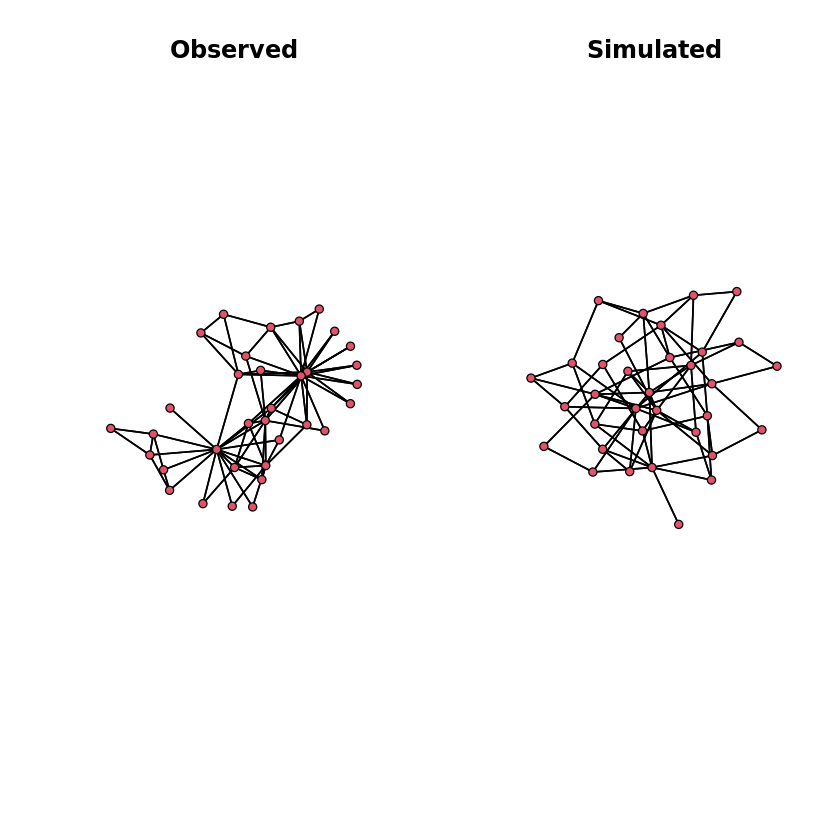

In [12]:
par( mfrow = c(1,2))
gplot( X , gmode='graph',main='Observed')
gplot( Xbern[1,,] , gmode='graph', main='Simulated')

#### Question 1

What are the main differences in structure?

> The simulated network appears to have shorter path lengths. The observed network does not have two distict clusters. There are no hubs in the simulated network. 

### Degree distribution

Calcualte the degree distributions for the observed network and compare it to the degree distributions of the simulated networks?

In [13]:
max.deg <- 30# no nodes have a degree that is as large as 30 to truncate the pltos
degrees.obs <- degree(X,# observed networks
                      gmode="graph")# recall, this is undirected
degree.dist.obs <- c( sum(degrees.obs==0),# we need to calculate the isolates separately
                      tabulate(degrees.obs, nbins=max.deg))# this is a table as before but pre-specified bins

For the 500 simulated networks we use `apply` to calculate the table many times

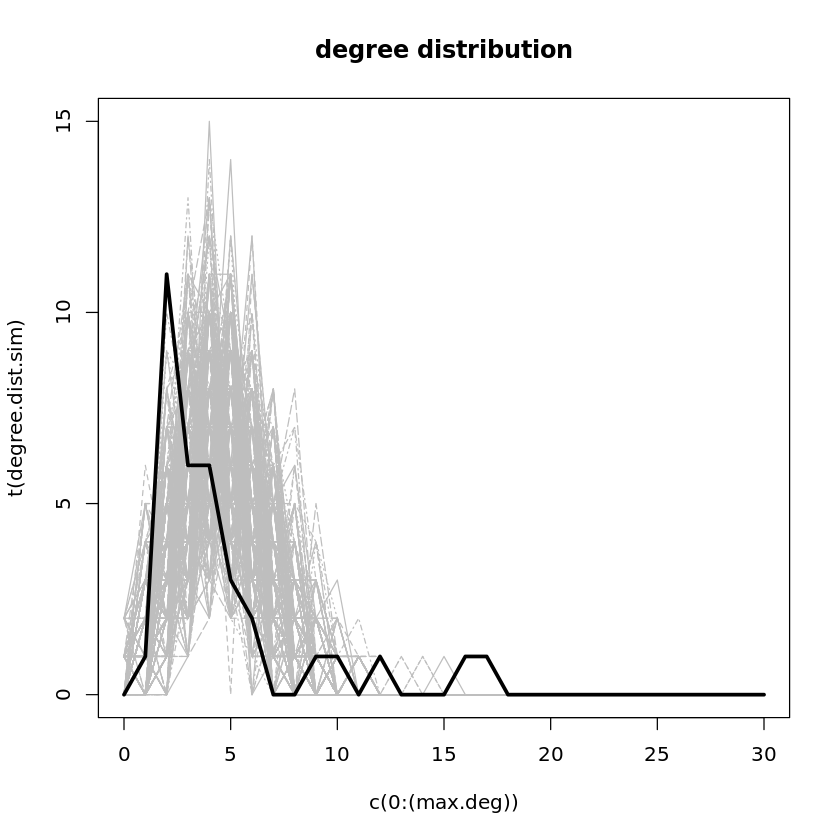

In [14]:
degrees.sim <-degree(Xbern,# the array of adjacency matrices
                     g=c(1:m), # we need to tell the functions which networks are calculating for
                     gmode="graph")# you can calculate the degree distributions for all graphs
degree.dist.sim <- cbind( matrix( colSums(degrees.sim==0),m,1),# a separate column for isolates
                  t(apply(degrees.sim,2,function(x) tabulate(x, nbins=max.deg) ) ) )# repeating the tabulate funditon
matplot(c(0:(max.deg)), # the range of degrees we want to plot frequencies for. Note: matplot plots several rows
        t(degree.dist.sim) ,# matplot wants the dataseries in columns, hence the transpose
        type ='l',
        col = 'grey',
        main='degree distribution' )
lines(c(0:(max.deg)),degree.dist.obs,col='black',lwd=3)# add the observed degree distribution as a black line

#### Question 2

What is the main difference between the observed and simulated networks?


> There are more high degree nodes in the observed dataset as seen in the skewed degree distribution.

### Centralisation

The degree distribution seems to indicate that not all nodes have the same probability of forming ties.

To test if the degrees are unevely distributied, test
* $H_0$: all nodes have the same tie-probability, against
* $H_1$: some nodes account for an 'unequal' share of the ties

Used centrality as your test statistic:
$$
T(X) = \sum_{i=1}^n \mid  d_{max}-d_i \mid
$$
and reject the null-hypothesis if 
$$
\Pr\{T(X) > T(X_{\mathrm{obs}})  \} < 0.05
$$
on the 5%-level.

First calculate the centralization index for the observed and simulated networks

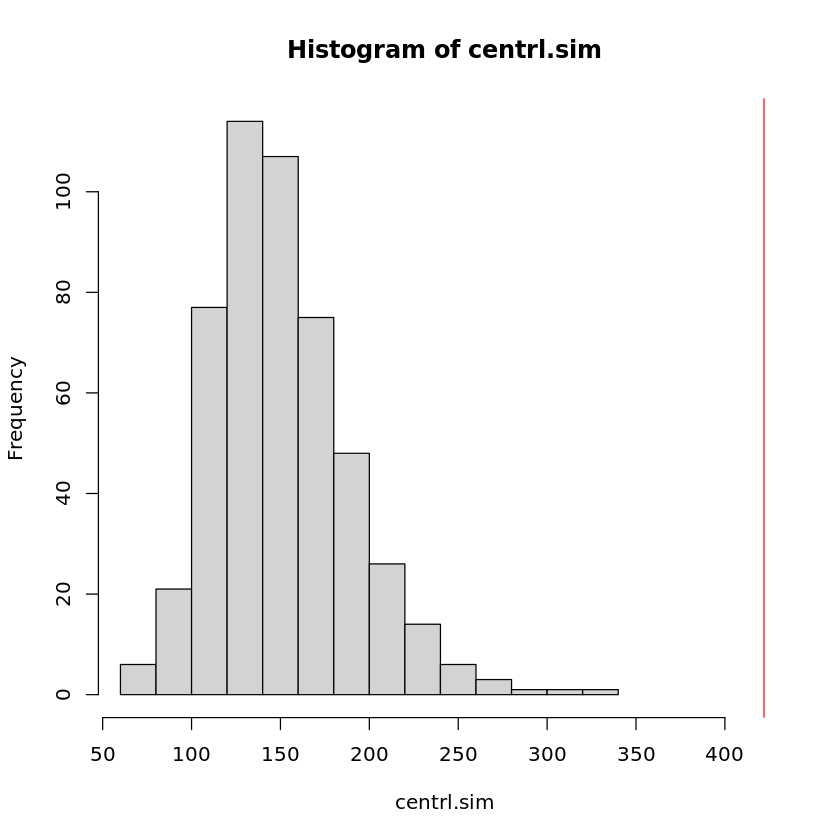

In [15]:
centrl.obs <- centralization(X,# observed network
                             degree,# base centralisation on the degrees
                             normalize=FALSE,# do not normalize 
                             mode='graph')# we are using undirected networks
centrl.sim <- centralization(Xbern,# the array of simulated networks
                             degree,normalize=FALSE, mode='graph')
hist( centrl.sim , xlim=range(centrl.obs  ,centrl.sim ))# make sure that the range contains our observed value
abline(v = centrl.obs ,col='red')

Calculate the test

In [16]:
mean(centrl.sim >= centrl.obs)# calculate the proportion of graphs that had higher or equal centralization

1 - mean(centrl.sim < centrl.obs)# equivalently, 1 minues less extreme

[1] 0

[1] 0

#### Question 3

Is the network more centralised 'than chance'?

> Yes, the statistic is significantly different from what you expect if every pair had the same tie-probability. In fact it is almost impossible to get this skewed a degree distribution with a Bernoulli model

So, depending on what you concluded, we would or we wouldn't expect to see such high-degree nodes if every dyad had the same tie-probability and people *form ties completely at random*.

### Clustering

Calculate and compare the triad census for the observed and random networks (for the $m$ random graphs, `triad.census` will produce an $m\times4$ table):

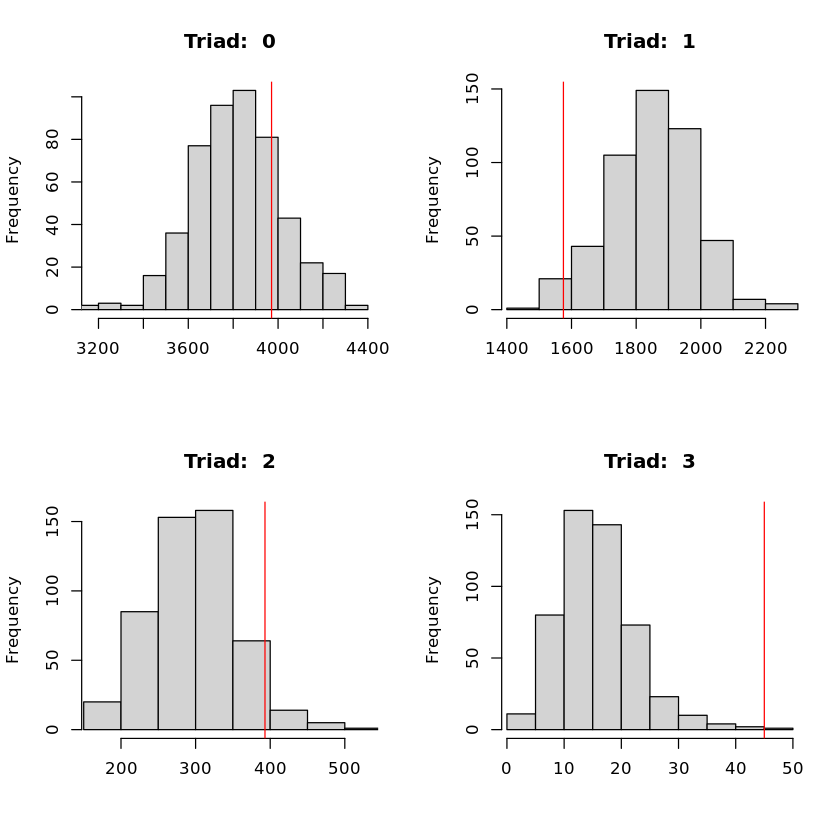

In [17]:
Tcens <- triad.census(Xbern, mode='graph') 
Tobs <- triad.census(X, mode='graph') 
par( mfrow = c(2,2) )
for (k in c(1:4)){
hist( Tcens[,k] , xlim=range( Tcens[,k], Tobs[,k]) , main = paste('Triad: ',k-1 ), xlab='')
abline( v = Tobs[,k], col="red")
}

As you might see, there are many more closed triads in the observed network than in the simulated networks. However, there are also more open triads. To appraise how large a proportion of triads are closed, use as your statistic the clustering coefficient:

$$
T(X) = \frac{3T_3(X)}{3T_3(X)+T_2(x)},
$$

First calculate and plot the clustering coefficient:


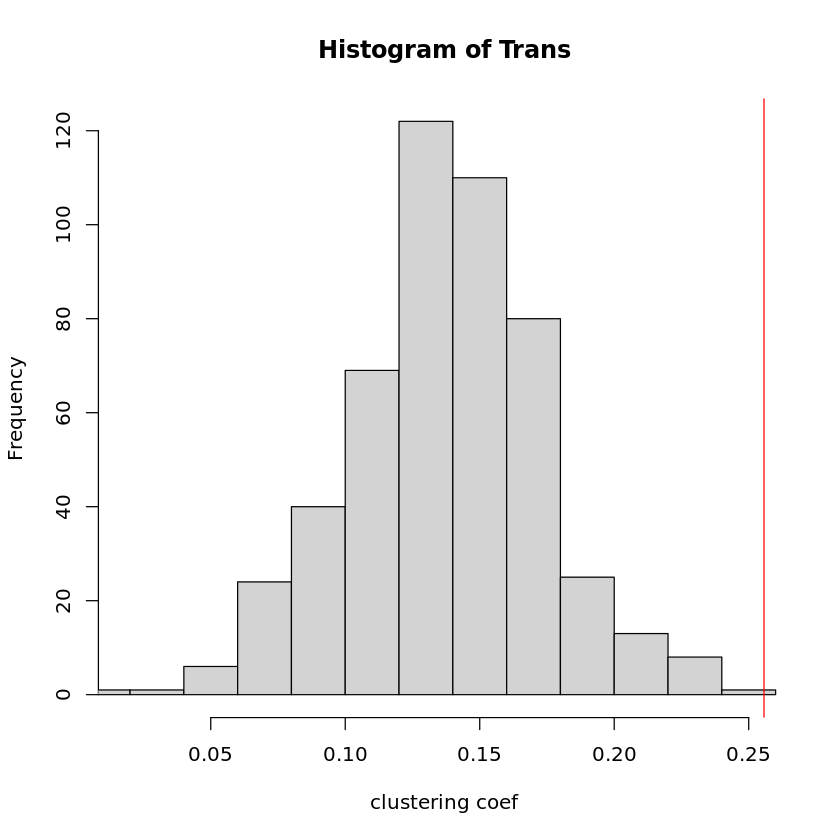

In [18]:
Trans <- gtrans(Xbern) 
hist( Trans , xlim=range( Trans,gtrans(X) ) , xlab ='clustering coef')
abline( v = gtrans(X), col="red")

Now test if the there is more clustering that by chance. Test
* $H_0$: there is no tendency to close triads, against
* $H_1$: open triads tend to close

Used clustering coefficient as your test statistic

In [19]:
mean(Trans  >= gtrans(X) )# calculate the proportion of graphs that had higher or equal clustering

[1] 0

#### Question 4

What proportion had as high or higher clustering as the observed network and what do you conclude?

> No random graphs had as high clustering. There is more clustering that we would expect by chance. In other words, if dyads formed ties at random with the same probability $p$, we would not see as much triad closure.

### Connectivity

Calcuate the distribution of geodesic distances:

Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist

Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist(x)$gdist)], nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(geodist(x)$gdist[upper.tri(geodist

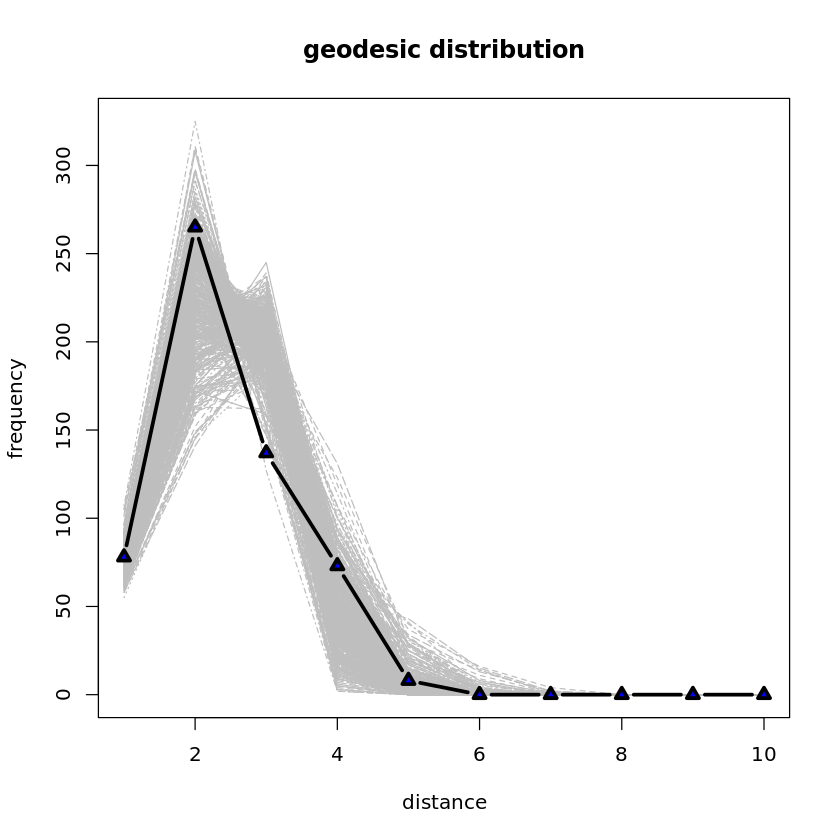

In [20]:
distances <- apply(Xbern,
                          1, 
                          function(x) tabulate( geodist( x )$gdist[upper.tri(geodist( x )$gdist)] , nbins=10 ) )  
                    
 
matplot(c(1:(10)), distances ,
        type ='l',
        col = 'grey',
        main='geodesic distribution' ,
        xlab='distance',
        ylab='frequency')
lines(c(1:(10)),
      tabulate( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ),
      pch=24,bg="blue",lty=1,type='b',
      col='black',lwd=3 )


The observed median distance is

In [21]:
median.dist.obs <- median( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ) 
median.dist.obs

[1] 2

The medians for simulated networks are

In [22]:
median.dist.sim <- apply( Xbern,
                          1,
                          function(x) median( geodist( x )$gdist[upper.tri(geodist( x )$gdist)] ) )
table(median.dist.sim )

median.dist.sim
  2   3 
357 143 

Now test if the the network is more or less connected than expected by chance. Test
* $H_0$: there is no tendency to have longer or shorted paths against
* $H_1$: paths are shorter or longer

Used the median distance as your test statistic and do a two-sided test


In [23]:
mean( median.dist.obs <= median.dist.sim )# Pr you get longer average paths
mean( median.dist.obs >= median.dist.sim)# Pr you get shorter average paths

[1] 1

[1] 0.714

#### Question 5
What do we conclude about connectivity?

> The network is not more or less connected than we would expect by chance

# 2. Conditionally uniform density

Some variation in our metrics for the Bernoulli graphs is due to random graphs only having the same density *on average*. Let $L(x) = \sum_{i<j}x_{ij}$ be the number of edges in a graph. The number of graphs with exactly $k$ edges
$$
\mathcal{X}_k= \{ x \in \mathcal{X} : L(x)=k \}
$$
is given by ${ M \choose k}$, where $M= { n \choose 2}$, and consequently the conditional distribution
$$
\Pr(X=x \mid L(x)= k ) = \frac{1}{{ M \choose k}}
$$

Note that are no longer deciding independently for each pair if there is a tie or not, rather we select $k$ pairs at random from the total set of pairs and decide that they will have tie.

We refer to this model as $X \thicksim U \mid L(X)= k$. In `sna`, the function `rgnm` generates random graphs with exactly the same number of ties as the observed network (same density).

If you do a plot of the density for the *previously generate* Bernoulli networks, you will see that we only get the right density on average:

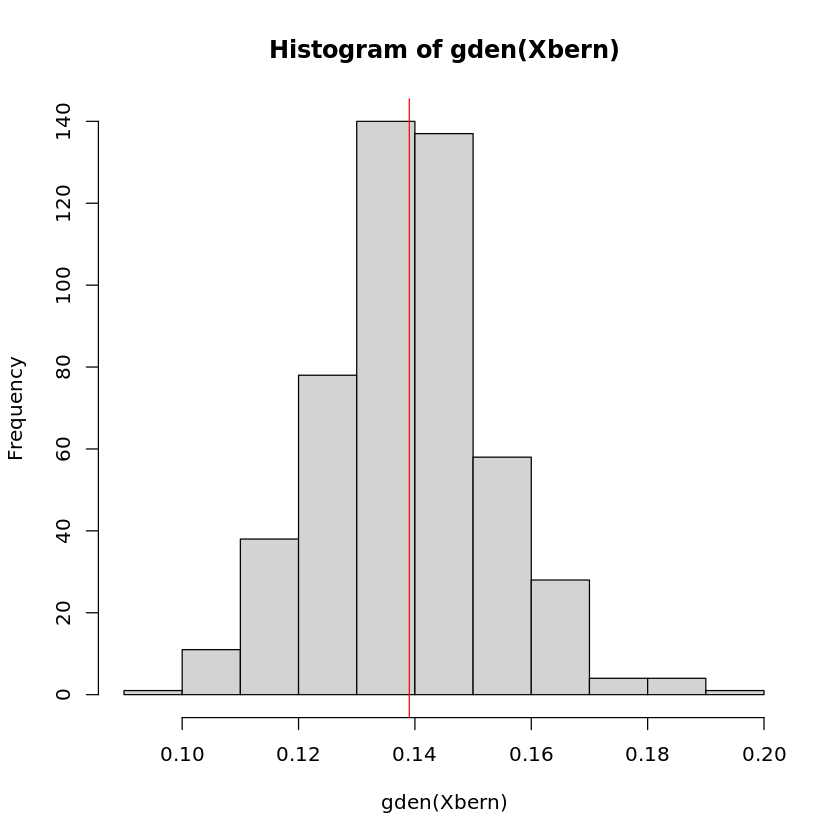

In [24]:
hist( gden(Xbern))
abline(v=gden(X),col='red')

Will our test change if all networks have the *exact same number of ties*?

Draw 500 networks from the $U | L$ distribution **NB: the number of graphs and size are swapped in this function**

In [25]:
m <- 500
Xunif <- rgnm( n = m,# generate 500 random networks # match network size
                 nv = n, # the size of the networks
                 m = sum(X)/2, # match the number of ties
                 mode='graph') # make sure these are undirected graphs

### Centralisation

Test centralisation using the centralization index (use the code above)


[1] 0

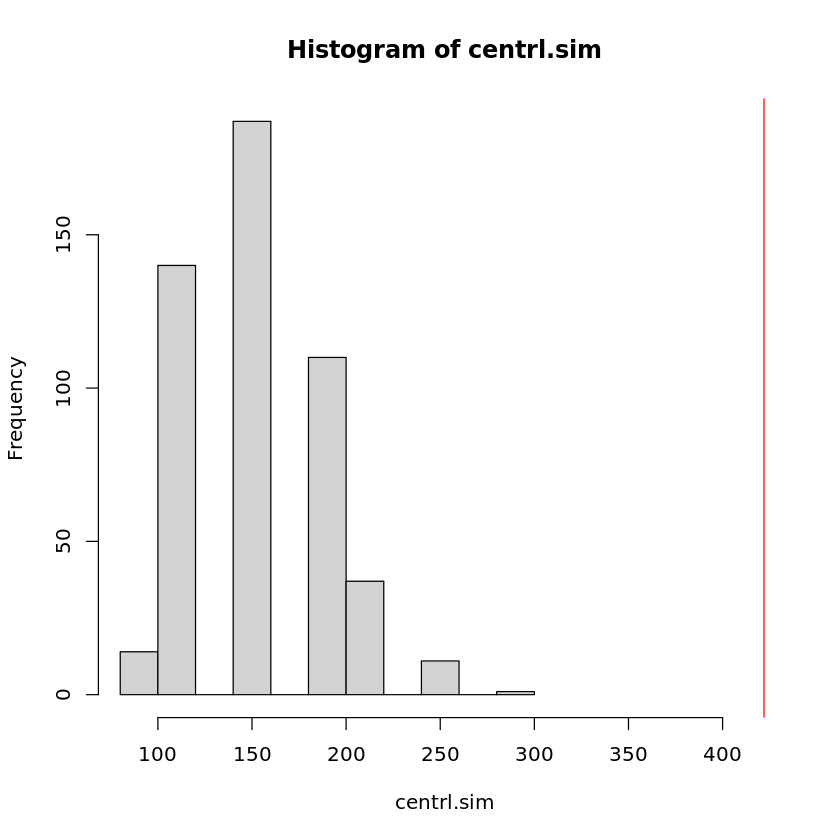

In [26]:
### BEGIN SOLUTION
centrl.sim <- centralization(Xunif,# the array of simulated networks
                             degree,
                             normalize=FALSE,
                             mode='graph')
hist( centrl.sim , xlim=range(centrl.obs  ,centrl.sim ))# make sure that the range contains our observed value
abline(v = centrl.obs ,col='red')
mean(centrl.sim >= centrl.obs)#
### END SOLUTION



#### Question 6

Does the conditionally uniform distribution better capture centralization? Motivate your answer.


> No, there is significantly more centralization in the observed network. Since the centralization measures the heterogeneity in degrees and the uniform model having less heterogenity, we would expect this model to have even less variation in degrees.

### Closure

Calculate and test clustering using the clustering coefficient


In [27]:
### BEGIN SOLUTION
Trans <- gtrans(Xunif) 
mean(Trans )
mean(Trans  >= gtrans(X ) )# 
### END SOLUTION

[1] 0.1372986

[1] 0

#### Question 7

Can the conditional uniform model explain clustering?


> No! The average transitivity score is about the same as for the Bernoulli model and the p-value is 0.


# 3. Conditionally uniform conditional on degree distribution

Since we cna conclude that the degree distribution is much more skewed in the observed data than in the random networks, we cannot say if discrepancies in clustering are due to many hubs or low clustering.

Like the $U \mid L(X)=k$ distribution, we define a distribution for graphs (not for tie-variables). We let $X \thicksim U \mid X_{\cdot+}=d$ mean that the distribution is uniform on all the graphs that have *the exact same degree distribution*. Thus
$$ 
\Pr( X = x) = \left\{
\begin{array}{lr}
	c^{-1},&\text{if } x_{\cdot+}=d\\
	0,&\text{else}
\end{array} 
\right. {\text{,}}
$$
where $x_{\cdot+}=(\sum_j x_{1j},\ldots,x_{nj})^{\top}$ is the vector of degrees, and $c = \mid \{ x \in \mathcal{X}: x_{\cdot+}=d \} \mid $.

There are several algorithms for simulating networks with fixed degree distribution and all of (the reliable ones) rely on Markov chain Monte Carlo (MCMC).

### Note on MCMC
The premise of MCMC is the you want to draw one variable $x$ from a distribution $p(x)$ but you cannot do that directly. What you can do though is to say how much more likely one realisation of a variable is relative to another. For example, let $x$ and $y$ be two networks and that the *target distribution* is $p(x)$. What we need to know in order to use MCMC is the ratio $p(x)/p(y)$ for all $x,y \in \mathcal{X}$. This allows us to generate a sequence of realisations
$$
x_0,x_1,x_2,\ldots,x_K
$$
of outcomes. This is an iterative scheme where you have an updating rule that takes an outcome $x_t$ and updates it to $x_{t+1}$, and this update relies on our ability to calculate $p(x)/p(y)$ for all $x,y \in \mathcal{X}$. In particular, if we are in state $x_t$, and we consider moving to state $x^{\ast}$, we know how much more or less likely the new state is relative to the old state $p(x^{*})/p(x_t)$. For networks, these updates are often incremental and you either set $x_{t+1}:=x^{\ast}$ or $x_{t+1}:=x_{t}$, depending on $p(x^{*})/p(x_t)$. Consequently, sometimes we stay in the same state, in the same network, for many iterations.

Burnin: to make sure that $x_t$ has 'forgotten' the initial state $x_0$, you usuall allow for a number of interations to pass - this is the burnin period.

Thinning: If you have an adequate burning and want to draw many outcomes, you may not have to do the same burnin again, instead you allow for a certain number of iterations bewtween sucessive sample points - the number of iterations you wait is called thinning.

### Simulate

The function that simulates networks require a `network` object, so first we need to translate the adjancency matrix to a netwokr object

In [28]:
X.net <- as.network(X, # our adjacency matrix that we want translated
                    directed=FALSE)# note the here an undirected network is indicated by directed=FALSE
X.net

 Network attributes:
  vertices = 34 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 78 
    missing edges= 0 
    non-missing edges= 78 

 Vertex attribute names: 
    vertex.names 

No edge attributes

To simulate we use a function from the `ergm` package:

In [29]:
Xudegs <- simulate(X.net~edges,
                    coef=c(0),# the role of coefficients will become clear further on
                    constraints=~degrees,# this guarantees that only networks with the same degree are generated
                    nsim=100,# we set the number of draws a bit lower to save time
                    control=control.simulate(MCMC.burnin=100000))# you need to bump up the default burnin, otherwise the networks are too similar to the starting point, the observed network

Note that the object returned is *a list of networks*, not an array as before.

To confirm that this network actually has the same degree distribution by looking at one of the networks:


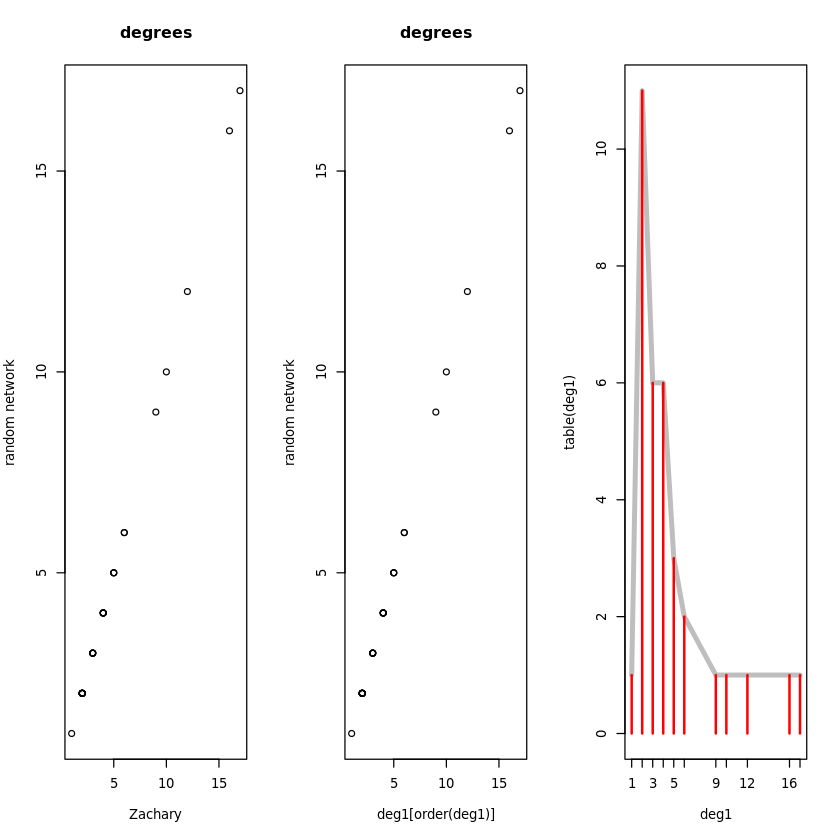

In [30]:
par(mfrow=c(1,3))
deg1 <- degree(X.net,  cmode='indegree')
deg2 <- degree(Xudegs[[5]],  cmode='indegree')# this is a list of networks, not an array, hence [[k]]
plot( deg1,deg2 ,xlab='Zachary', ylab ='random network',main='degrees')#
plot( deg1[order(deg1)],deg2[order(deg2)] ,ylab ='random network',main='degrees')# the degree distribution is the same but not the same nodes have the same degrees
plot( table(deg1), type='l',col='grey',lwd=4)
lines( table(deg2) ,col='red' )

### Closure

Now that we have fixed the degree distribution, is there closure *above what can be explained by degree heterogenity*. In other words, was the significantly large clustering compared to e.g. the Bernoulli model due to some nodes being hubs?

Calculate and test clustering using the clustering coefficient (do a histogram of clustering coefficient to aid your conlclusions). Hint: `gtrans` works the same on an array of networks and a list of networks.


[1] 0.1

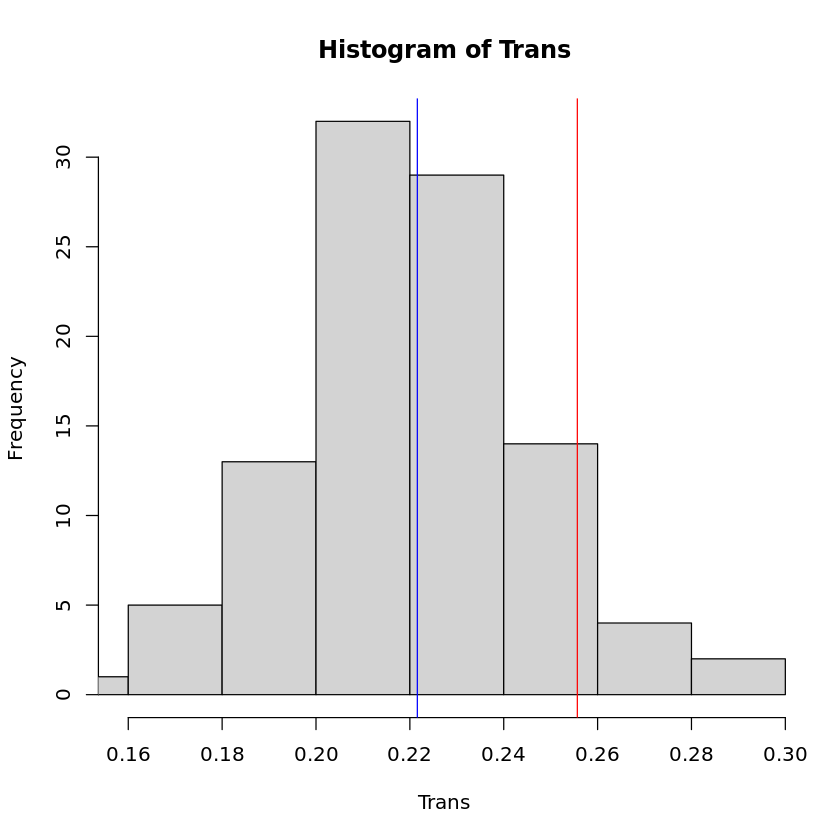

In [31]:
### BEGIN SOLUTION
Trans <- gtrans(Xudegs) 
hist( Trans , xlim=range( Trans ,gtrans(X ) ) )
abline(v= mean(Trans ), col='blue')
abline(v= gtrans(X ), col='red')
mean(Trans  >= gtrans(X ) )# 
### END SOLUTION

#### Question 8

Does the heterogenity in the degree distribution explain clustering?


> The avergae clustering coefficient in the conditionally uniform degree distribution model is 0.22 which is close to the observed clustering coefficient of 0.26. The p-value of the statistic in the one-sided test is about 0.09, meaning that clustering is only significantly different on the 10%-level of significance.

### Path lengths

Calcuate the distribution of geodesic distances:

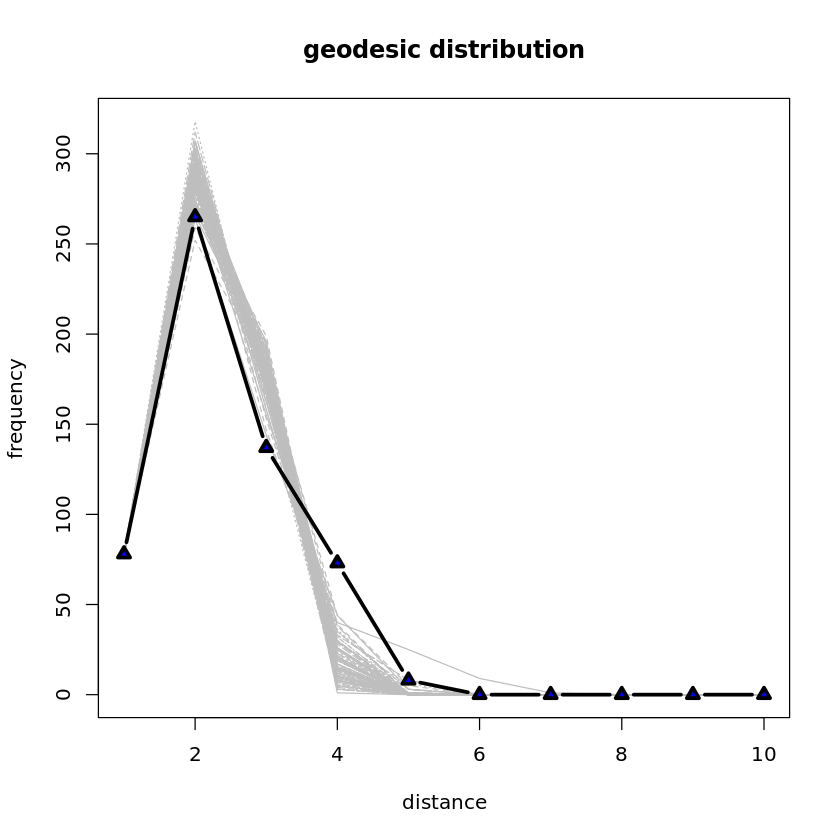

In [32]:
# because Xudegs is a list it is a little more complicated to use built in sna functions
distances <- matrix(0,10,100)
median.dist.sim <- matrix(0,1,100)
mean.dist.sim <- matrix(0,1,100)
for (k in c(1:100))
{
  temp.dist <- geodist( Xudegs[[k]] )$gdist[upper.tri(geodist( Xudegs[[k]] )$gdist)]# temporary distances
  distances[,k] <- tabulate( temp.dist, 
                             nbins=10 ) # tabulate distances
  median.dist.sim[k] <- median(temp.dist )# save median distance
  mean.dist.sim[k] <- mean(temp.dist )# save mean distance
}

matplot(c(1:(10)), distances ,
        type ='l',
        col ='grey',
        main='geodesic distribution' ,
        xlab='distance',
        ylab='frequency')
lines(c(1:(10)),
      tabulate( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ),
      pch=24,bg="blue",lty=1,type='b',
      col='black',lwd=3 )

#### Question 9

Do a one-side test to test if observed path-lengths are longer than what is explained by the degree-distribution - use both median distance and mean distance

In [33]:
median.dist.obs <- median( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ) 
mean.dist.obs <- mean( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ) 
### BEGIN SOLUTION 
mean( median.dist.obs >= median.dist.sim)# calculate the proportion of graphs that longer pathlengths
mean(mean.dist.sim >= mean.dist.obs)# calculate the proportion of graphs that longer pathlengths
### END SOLUTION

[1] 1

[1] 0.01

> In terms of median distance the conditionally uniform distributions are not shorter than the observed. Using the mean rather the median, we see that the probability of getting an average distance as lasrge as 2.41 or larger is close to zero. 

#### Question 10

How would you summarise the two results for clustering and connectivity taken together? What does the degree distribution explain and what does it not explained compared (compare with the Bernoulli graph)


> The network has more skewed degree distribution that the observed network and assuming the same tie-probablity for all pairs also gives too little clustering. The clustering can in part be explained by the degree-heterogeneity but this degree distribution gives rise to too long pathways.


# 4. ERGM 
Both clustering and degree-heterogeneity differ from the Bernoulli model - actors to not form ties at random. Controlling for the fact that some actors are more 'popular' partly explains clustering. However, the clustering increases the distances in the graph. In addition, using conditionally uniform degree model we can see how much of the clustering that the degree distribution is responsible for but we cannot know how much of the degree heterogenity that is explained by clustering.

## Definition

An introduction to ERGMs is given in the slides. Formally, an ERGM is a model
$$
\Pr( X = x \mid \theta) = \frac{ \exp \{ \theta^{\top}z(x)  \}   }{ \sum_{x \in \mathcal{X} } \exp \{ \theta^{\top}z(x) \} }
$$

where
* $\theta$ is a vector of statitical parameters
* $z(x)$ is a vector of statistics calculated on $x$
* the denominator is a sum over all graphs ensuring that the probaility sums to one

A positive parameter $\theta$ means that you expect more of the configuration associated with its statistic, $z$

### Example
If $z(x)=L(x)$, the only model statistic is the number of edges in the graph. This model is equivalent to $Bern(p)$, where
$$
\theta = - \log\left( \frac{1}{p-1}\right)
$$
or, expressed in terms of $p$
$$
p= \frac{e^{\theta L(x)}}{1+e^{\theta L(x)}}
$$

## Properties

A property of ERGM is that you can set the values of the expected statistics. The expected statistis
$$
E_{\theta} \{ z(X) \} = \sum_{x \in \mathcal{x}} z(x)\Pr( X = x \mid \theta) 
$$
are completely determined by the parameters. 

### Simulate

Draw from an ERGM that has the same number of edges as the observed network and that gets the number of two-stars and triangles correct on average. In particular, we use the statistics:

* two-stars: $\sum_{ i ,j,k }x_{ij}x_{ik}$
* triangles: $\sum_{ i ,j,k}x_{ij}x_{ik}x_{jk}$

We will use the parameters $\theta = \left( 0.1587,  0.1744 \right)^{\top}$. This means that we will favour graphs that have more two-paths - every high-degree nodes will contribute many two-stars - and more triangles.


In [36]:
star.coef <- 0.1587# the coefficeints are estimated using: est <- ergm(  ~ kstar(2)+triangle, constraints =~ edges )
triangle.coef <- 0.1744  
Xergm <- simulate(X.net~ kstar(2)+triangle,# the linear combiation in the exponent
                    coef=c(star.coef,triangle.coef),
                    constraints=~edges,# this is what does it degreedist is based on padgbus.net
                    nsim=100,
                    control=control.simulate(MCMC.burnin=100000))# 

Check the triad census

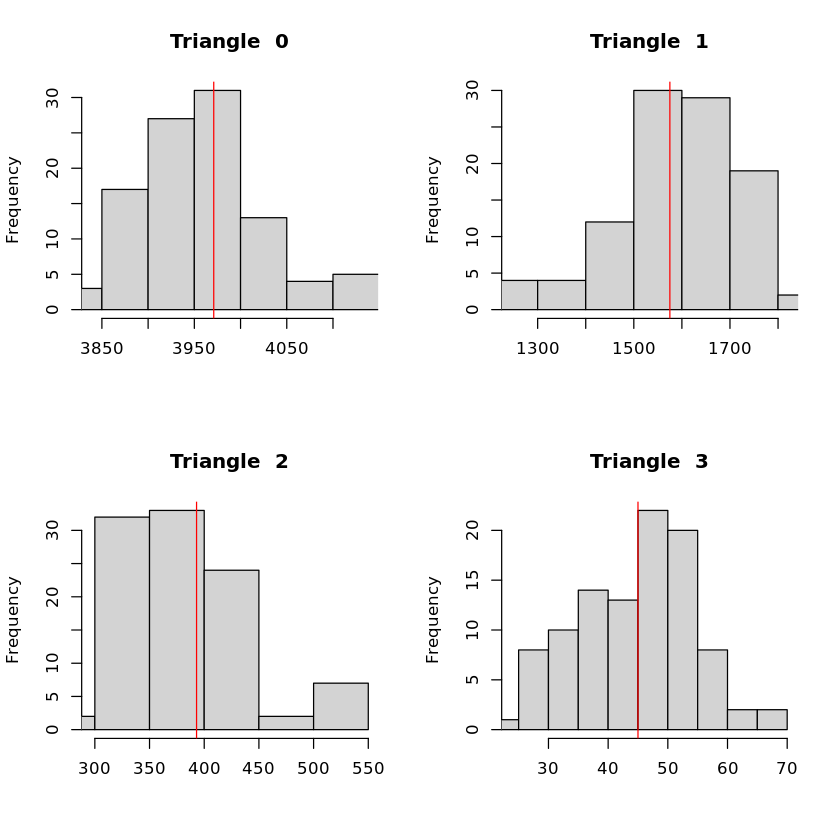

In [37]:
Tcens <- triad.census(Xergm, mode='graph') 
Tobs <- triad.census(X, mode='graph') 
par( mfrow = c(2,2) )
for (k in c(1:4))
{
hist( Tcens[,k] , xlim=range( Tcens[,k], Tobs[,k]) , xlab ='', main=paste('Triangle ',k-1))
abline( v = Tobs[,k], col="red")
}

This model seems to replicate the triad census very well.

Check the degree distribution

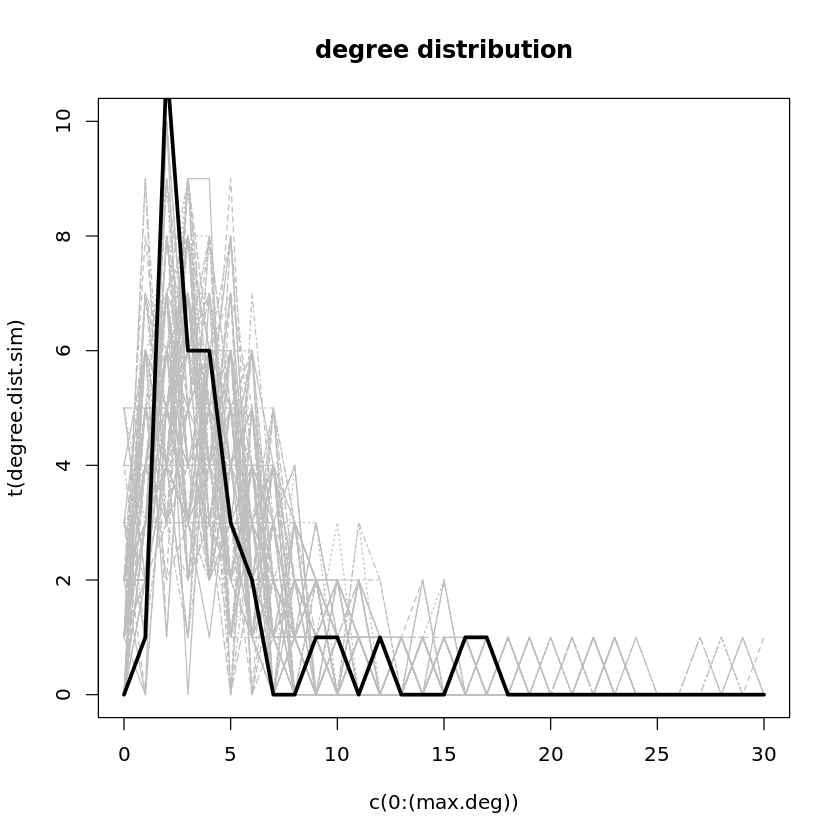

In [38]:
m <- 100
degrees.sim <-degree(Xergm,g=c(1:m), gmode="graph")# you can calculate the degree distributions for all graphs
degree.dist.sim <- cbind( matrix( colSums(degrees.sim==0),m,1),
                  t(apply(degrees.sim,2,function(x) tabulate(x, nbins=max.deg) ) ) )# when tabulating we need to add the number of isolates 
matplot(c(0:(max.deg)), t(degree.dist.sim) ,
        type ='l',
        col = 'grey',
        main='degree distribution' )
lines(c(0:(max.deg)),degree.dist.obs,col='black',lwd=3)

The shape of the degree distribution seems to be similar.

#### Question 11
Does the ERGM explain centralization?

Test centralisation using the centralization index (use the code above)

[1] 0.52

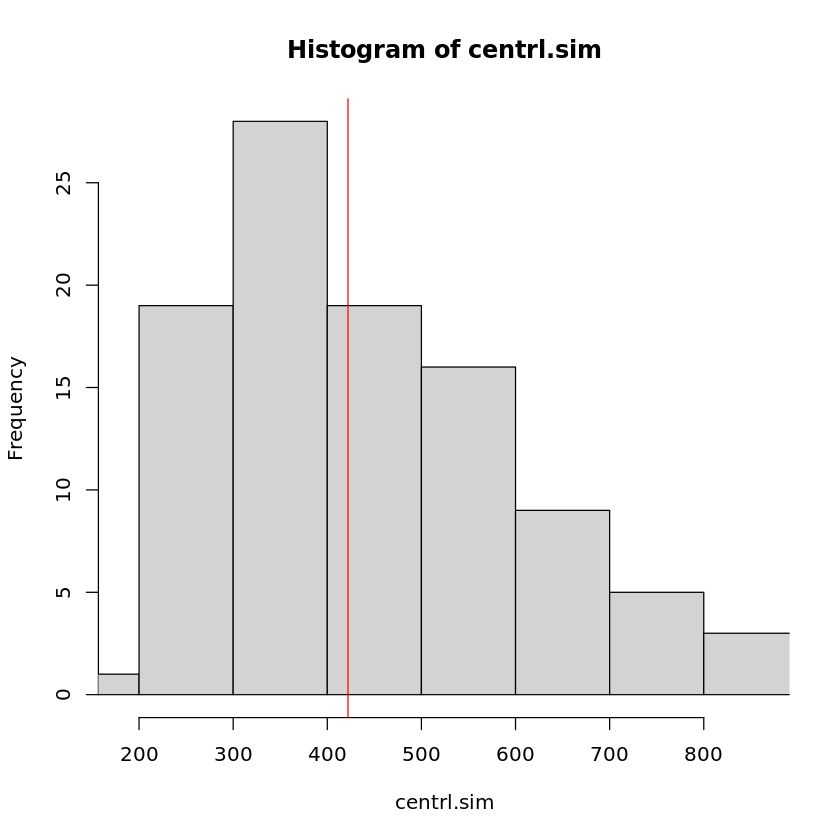

In [39]:
### BEGIN SOLUTION 
centrl.sim <- centralization(Xergm,# the array of simulated networks
                             degree,normalize=FALSE, mode='graph')
hist( centrl.sim , xlim=range(centrl.obs  ,centrl.sim ))# make sure that the range contains our observed value
abline(v = centrl.obs ,col='red')
mean(centrl.sim >= centrl.obs)#
### END SOLUTION 

> Yes, the two-star and triangle parameter manage to explain the centrlaisation as the simulated average centralization index is about 514 and close to the observed 422. 

#### Optional exercise
As an own excercise, you can analyse how the two-star statistic relates to the variance in the degree distribution. Letting $\bar{d}$ be the average degree, the sample *degree variance* (more or less the same as centralization index) can  be written
$$
\frac{\sum_i (d_i-\bar{d})^2}{n-1}=\frac{\sum_id_i^2-\tfrac{\left(\sum_i d_i \right)^2}{n}}{n-1}
$$
and assuming that the average degree is fixed, the variance depends on how large the first sum is. This sum can be written as
$$
\sum_id_i^2=\sum_i \left(\sum_j x_{ij} \right)^2=\sum_i \sum_{j,k}x_{ij}x_{ik}
$$
which is exactly the two-star statistic.

### Path lengths

Calcuate the distribution of geodesic distnaces:

Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in tabulate(temp.dist, nbins = 10):
“NAs introduced by coercion to integer range”
Warning message in t

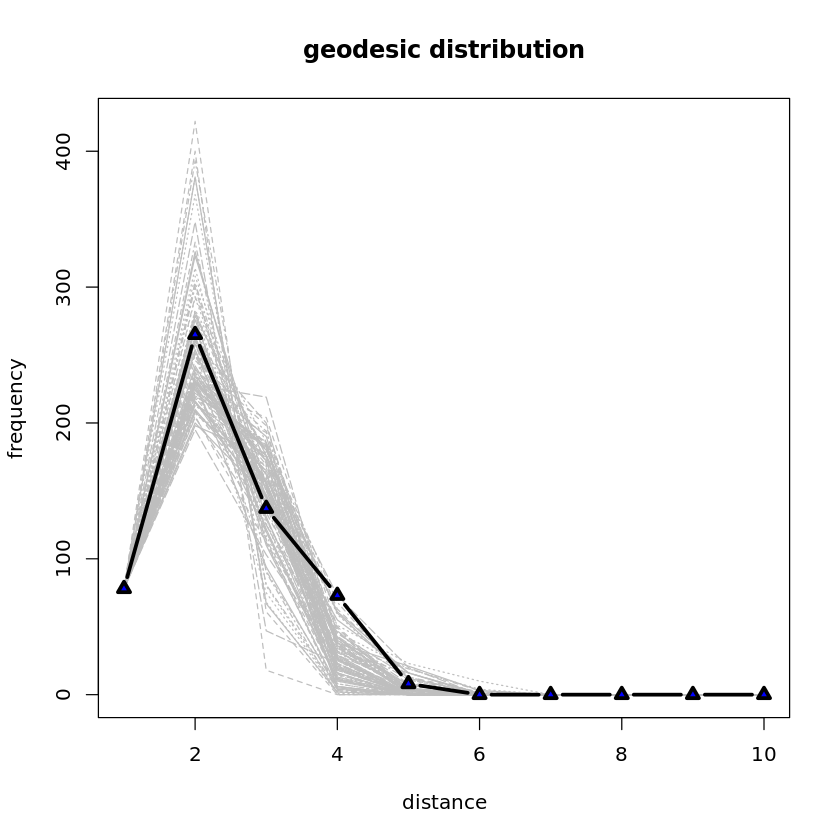

In [40]:
# because Xergm is a list it is a little more complicated to use built in sna functions
distances <- matrix(0,10,100)
median.dist.sim <- matrix(0,1,100)
mean.dist.sim <- matrix(0,1,100)
for (k in c(1:100))
{
  temp.dist <- geodist( Xergm[[k]] )$gdist[upper.tri(geodist( Xergm[[k]] )$gdist)]# temporary distances
  distances[,k] <- tabulate( temp.dist, 
                             nbins=10 ) # tabulate distances
  median.dist.sim[k] <- median(temp.dist )# save median distance
  mean.dist.sim[k] <- median(temp.dist )# save median distance
}

matplot(c(1:(10)), distances ,
        type ='l',
        col ='grey',
        main='geodesic distribution' ,
        xlab='distance',
        ylab='frequency')
lines(c(1:(10)),
      tabulate( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ),
      pch=24,bg="blue",lty=1,type='b',
      col='black',lwd=3 )

#### Question 12

Do a one-side test to test if observed path-lengths are longer than what is explained by the degree-distribution - use both median distance and mean distance


In [41]:
mean.dist.obs <- mean( geodist( X )$gdist[upper.tri(geodist( X )$gdist)] , nbins=10 ) 
### BEGIN SOLUTION 
mean( median.dist.obs >= median.dist.sim)# calculate the proportion of graphs that longer pathlengths
mean(mean.dist.sim >= mean.dist.obs)# calculate the proportion of graphs that longer pathlengths
### END SOLUTION 

[1] 0.97

[1] 0.03

>  The path-lengths in the observed networks are still larger on average than in the simulated networks but the fit is slightly better than form the conditionally uniform degree model.


# Summary

So, we have seen powerfull methods for testing importance mechanisms in tie-formation or have we just listed multiple ways of proving that *people do not form ties at random*?

Testing observed patterns against null-distributions has its limitations - we only ever know what we reject. The ERGM and other models provide opportunites for modelling data rather than modelling what data isn't.